In [1]:
# https://keras.io/
# !pip install -q keras 
# import keras 
# print(keras.__version__)

In [2]:
import keras
import time
from keras.datasets import cifar10
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Concatenate
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, Callback

Using TensorFlow backend.


In [3]:
# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf
from keras import backend as k

# Don't pre-allocate memory; allocate as-needed
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))

In [4]:
class SGDRScheduler(Callback):
    
    def __init__(self,
                 min_lr,
                 max_lr,
                 steps_per_epoch,
                 lr_decay,
                 cycle_length,
                 mult_factor):

        self.min_lr = min_lr
        self.max_lr = max_lr
        self.lr_decay = lr_decay

        self.batch_since_restart = 0
        self.next_restart = cycle_length

        self.steps_per_epoch = steps_per_epoch

        self.cycle_length = cycle_length
        self.mult_factor = mult_factor

        self.history = {}

    def clr(self):
        '''Calculate the learning rate.'''
        fraction_to_restart = self.batch_since_restart / (self.steps_per_epoch * self.cycle_length)
        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + np.cos(fraction_to_restart * np.pi))
        return lr

    def on_train_begin(self, logs={}):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.max_lr)

    def on_batch_end(self, batch, logs={}):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        self.batch_since_restart += 1
        K.set_value(self.model.optimizer.lr, self.clr())

    def on_epoch_end(self, epoch, logs={}):
        '''Check for end of current cycle, apply restarts when necessary.'''
        if epoch + 1 == self.next_restart:
            self.batch_since_restart = 0
            self.cycle_length = np.ceil(self.cycle_length * self.mult_factor)
            self.next_restart += self.cycle_length
            self.max_lr *= self.lr_decay
            self.best_weights = self.model.get_weights()

    def on_train_end(self, logs={}):
        '''Set weights to the values from the end of the most recent cycle for best performance.'''
        self.model.set_weights(self.best_weights)

In [5]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [6]:
# Hyperparameters
# batch_size = 32
# num_classes =  10
# epochs = 50
# l = 40
# num_filter = 10
# compression = 0.5
# dropout_rate = 0

batch_size = 64
num_classes =  10
epochs = 50
l = 16
num_filter = 12
compression = 1
dropout_rate = 0.2


In [7]:
# Load CIFAR10 Data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
img_height, img_width, channel = x_train.shape[1],x_train.shape[2],x_train.shape[3]

# convert to one hot encoding 
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


In [8]:
# Dense Block
def add_denseblock(input, num_filter, dropout_rate):
    global compression
    temp = input
    for _ in range(l):
        BatchNorm = BatchNormalization()(temp)
        relu = Activation('relu')(BatchNorm)
        Conv2D_3_3 = Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
        if dropout_rate>0:
          Conv2D_3_3 = Dropout(dropout_rate)(Conv2D_3_3)
        concat = Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

In [9]:
def add_transition(input, num_filter, dropout_rate):
    global compression
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
    if dropout_rate>0:
      Conv2D_BottleNeck = Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    
    return avg

In [10]:
def output_layer(input):
    global compression
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    AvgPooling = AveragePooling2D(pool_size=(2,2))(relu)
    flat = Flatten()(AvgPooling)
    output = Dense(num_classes, activation='softmax')(flat)
    
    return output

In [11]:
input = Input(shape=(img_height, img_width, channel,))
First_Conv2D = Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(input)

First_Block = add_denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = add_transition(First_Block, num_filter, dropout_rate)

Second_Block = add_denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = add_transition(Second_Block, num_filter, dropout_rate)

Third_Block = add_denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = add_transition(Third_Block, num_filter, dropout_rate)

Last_Block = add_denseblock(Third_Transition,  num_filter, dropout_rate=0.2)
output = output_layer(Last_Block)


In [12]:
model = Model(inputs=[input], outputs=[output])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 12)   324         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 12)   48          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 12)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [13]:
# ak - block 3 SGDRScheduler

schedule = SGDRScheduler(min_lr=1e-5,
                                     max_lr=1e-1,
                                     steps_per_epoch=2*(x_train.shape[0]//batch_size),
                                     lr_decay=1,
                                     cycle_length=5,
                                     mult_factor=1.5)

# checkpointer = ModelCheckpoint(filepath='v6_2_weights.{epoch:02d}-{val_loss:.2f}--{val_acc:.2f}.hdf5',monitor='val_acc', mode=max, verbose=1, save_best_only=True, save_weights_only=True)



# keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=0, mode='auto'
#                               , baseline=None, restore_best_weights=False)

earlystopper = EarlyStopping(monitor='val_loss', min_delta=1, patience=20, verbose=1,mode='min')


In [14]:
# determine Loss function and Optimizer
# decay=10e-4,momentum=0.9
sgd = SGD(momentum=1)

model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [16]:
# ak - block 4 - image aug

# we can compare the performance with or without data augmentation
data_augmentation = True
callbacks_list=[schedule,earlystopper]
start = time.time()
if not data_augmentation:
    print('Not using data augmentation.')
    model_info = model.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(x_test, y_test),
        shuffle=True,
        callbacks=callbacks_list
        )
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by dataset std
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in 0 to 180 degrees
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    
    model_info = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        steps_per_epoch=3*(x_train.shape[0]//batch_size),
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        callbacks=callbacks_list
                       )

end = time.time()
print ("Model took %0.2f seconds to train"%(end - start)/3600)

plot_model_history(model_info)

Using real-time data augmentation.
Epoch 1/50
2343/2343 [==============================] - 264s 113ms/step - loss: 0.9702 - acc: 0.6521 - val_loss: 1.0551 - val_acc: 0.6679
Epoch 2/50
2343/2343 [==============================] - 266s 114ms/step - loss: 0.8324 - acc: 0.7026 - val_loss: 1.0436 - val_acc: 0.6869
Epoch 3/50
2343/2343 [==============================] - 253s 108ms/step - loss: 0.8050 - acc: 0.7130 - val_loss: 1.0672 - val_acc: 0.6769
Epoch 4/50
2343/2343 [==============================] - 248s 106ms/step - loss: 0.8204 - acc: 0.7070 - val_loss: 1.2928 - val_acc: 0.6318
Epoch 5/50
2343/2343 [==============================] - 263s 112ms/step - loss: 0.7962 - acc: 0.7190 - val_loss: 1.3054 - val_acc: 0.6430
Epoch 6/50
2343/2343 [==============================] - 262s 112ms/step - loss: 0.7163 - acc: 0.7482 - val_loss: 0.9423 - val_acc: 0.7293
Epoch 7/50
2343/2343 [==============================] - 263s 112ms/step - loss: 0.6229 - acc: 0.7823 - val_loss: 0.8103 - val_acc: 0.7630

TypeError: unsupported operand type(s) for /: 'str' and 'int'

Model took 1.51 hours to train


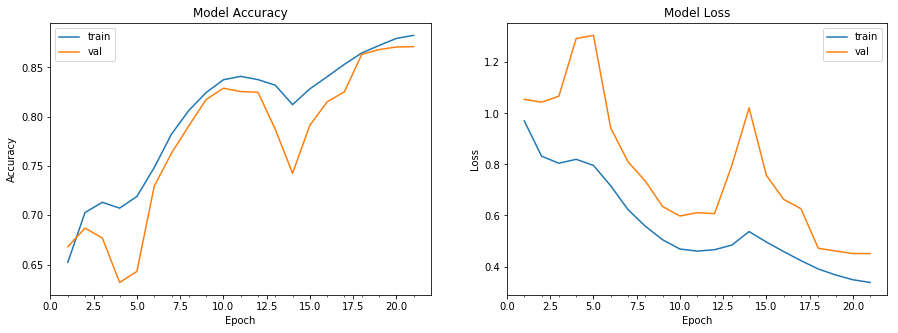

In [23]:
print ("Model took %0.2f hours to train"%((end - start)/3600))

plot_model_history(model_info)

In [ ]:
# lr_reducer      = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1),
#                                    cooldown=0, patience=10, min_lr=0.5e-6)
# early_stopper   = EarlyStopping(monitor='val_acc', min_delta=0.001, patience=20)

# model.fit(x_train, y_train,
#                     batch_size=batch_size,
#                     epochs=50,
#                     verbose=1,
#                     validation_data=(x_test, y_test),
#                     callbacks=[lr_reducer,early_stopper])

In [24]:
# Test the model
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 4s 409us/step
Test loss: 0.7957158389568328
Test accuracy: 0.7872


In [25]:
# Save the trained weights in to .h5 format
model.save_weights("DNST_model_weights_v6_3.h5")
print("Saved model to disk")

Saved model to disk
